# Deep Q Learning to Play Space Invaders

In [1]:
# Import packages
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
import random
import time

from tensorflow.keras.models import Sequential
import tensorflow as tf
print(tf.__version__)

from skimage import transform 
from skimage.color import rgb2gray 

1.15.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13763750128443673751
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14890736581093881885
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 12092106343
locality {
  bus_id: 1
  links {
  }
}
incarnation: 488258748241305863
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7077692614101600456
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## [1] Create the environment

In [4]:
# Create our environment
env = gym.make("SpaceInvaders-v0")

# Get state and action space
state_size = env.observation_space
action_size = env.action_space.n

print("The size of our frame is: ", state_size)
print("The action size is : ", action_size)

The size of our frame is:  Box(210, 160, 3)
The action size is :  6


## [2] Preprocess Functions

In [5]:
# plotting the images in a list
def plot_frames(display_list, title_list = None):
    
    plt.figure(figsize=(10, 10))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1) 
        
        if title_list:
            plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')

    plt.show()

### [2.1] Image Filtering

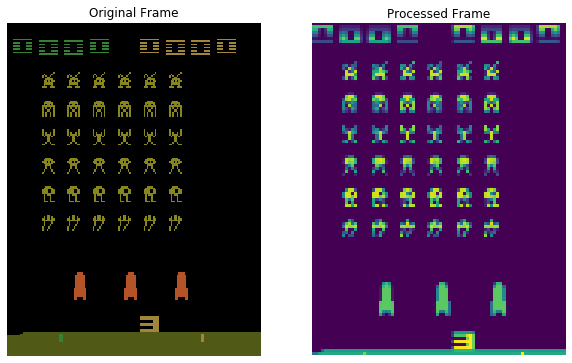

Size before process:  (210, 160, 3)
Size after process:  (110, 84)


In [6]:
# Normalise, turn into greyscale and crop image
frame_size = (110, 84)
def preprocess_frame(frame):
    # Greyscale frame 
    gray = rgb2gray(frame)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[8:-12,4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    # Thanks to Mikołaj Walkowiak
    preprocessed_frame = transform.resize(normalized_frame, frame_size)
    
    return preprocessed_frame # 110x84x1 frame

# Test out the preprocess procedure
sample_state = env.reset()
sample_state_processed = preprocess_frame(sample_state)
plot_frames([sample_state, sample_state_processed], ['Original Frame','Processed Frame'])

print('Size before process: ', sample_state.shape)
print('Size after process: ', sample_state_processed.shape)

### [2.2] Stack the frames

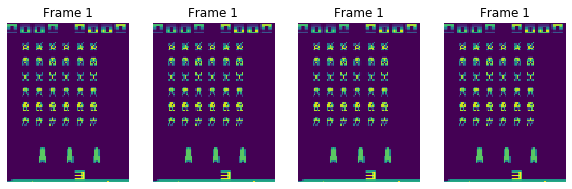

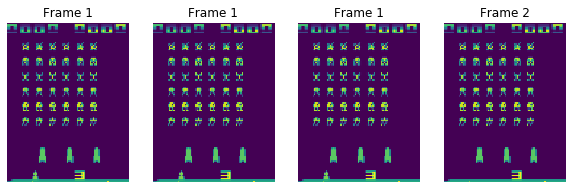

In [7]:
# Given a stacked frame, append a new frame to this stack
def stack_frames(stacked_frames, new_frame, is_new_episode):
    
    # Preprocess frame before stacking
    frame = preprocess_frame(new_frame)
    
    # if new episode make copies of frame, else append frame
    if is_new_episode:
        
        # Clear stacked frames
        stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)
        
        # Append the same frame to the stack stack_size times
        for _ in range(0, stack_size):
            stacked_frames.append(frame)
        
        # Return a numpy array for the stacked frame
        stacked_states = np.stack(stacked_frames, axis = 2)
    
    else:
        stacked_frames.append(frame)
        stacked_states = np.stack(stacked_frames, axis = 2)
    
    return stacked_states, stacked_frames

# Stacking frames to provide input = [frame 1, frame 2, frame 3, frame 4]
stack_size = 4

# Initialise with array of zeros
stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)

# Test out the stack_frames procedure
sample_state = env.reset()
stacked_states, stacked_frames = stack_frames(stacked_frames, sample_state, True)
plot_frames(stacked_frames, ['Frame ' + str(1) for i in range(0,4)])

for i in range(0, 4):
    sample_next_state, _ , done , _  = env.step(env.action_space.sample())
    stacked_states, stacked_frames = stack_frames(stacked_frames, sample_next_state, False)
    
plot_frames(stacked_frames, ['Frame ' + str(1) for i in range(1,4)] + ['Frame 2'] )

## 3 Training 

In [8]:
# Define paramters for training 
LEARNING_RATE = 0.001
MEMORY_SIZE = 100000
INITIAL_MEMORY_SIZE = 50000
BATCH_SIZE = 64
MAX_STEP = 50000
UPDATE_MODEL_STEP = 10000
TRAINING_FREQUENCY = 4
LOG_FREQUENCY = TRAINING_FREQUENCY*5


EXPLORATION_RATE = 1
EXPLORATION_DECAY = 0.9999
EXPLORATION_MIN = 0.01

GAMMA = 0.9

### [3.1] Create Deep Q Neural Network

In [9]:
class DQNetworks:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            self.mean_target = tf.reduce_mean(self.target_Q)
            
            # Input the Importance sampling weights here
            self.IS_weights = tf.placeholder(tf.float32, [None], name="IS_weights")
            
            """
            First convnet:
            CNN
            ELU
            """
            # Input is 110x84x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides = [4,4],
                                         padding = "VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            with tf.variable_scope('conv1', reuse=True):
                self.conv1w = tf.get_variable('kernel')
                self.conv1b = tf.get_variable('bias')
                
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")

                
            """
            Second convnet:
            CNN
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 64,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")
            
            with tf.variable_scope('conv2', reuse=True):
                self.conv2w = tf.get_variable('kernel')
                self.conv2b = tf.get_variable('bias')
                

            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out")            
            
            """
            Third convnet:
            CNN
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 64,
                                 kernel_size = [3,3],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")
            
            with tf.variable_scope('conv3', reuse=True):
                self.conv3w = tf.get_variable('kernel')
                self.conv3b = tf.get_variable('bias')

            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            self.flatten = tf.contrib.layers.flatten(self.conv3_out)
            
            ## Here to separate into two streams
            # The one to calculate V(s)
            self.value_fc = tf.layers.dense(inputs = self.flatten,
                                            units = 512,
                                            activation = tf.nn.elu,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            name="value_fc")
            
            with tf.variable_scope('value_fc', reuse=True):
                self.value_fcw = tf.get_variable('kernel')
                self.value_fcb = tf.get_variable('bias')
                
            self.value =  tf.layers.dense(inputs = self.value_fc,
                                          units = 1,
                                          activation = None,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          name="value")
            
            # The one to calculate A(s,a)
            self.advantage_fc = tf.layers.dense(inputs = self.flatten,
                                                units = 512,
                                                activation = tf.nn.elu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                                name="advantage_fc")
            
            with tf.variable_scope('advantage_fc', reuse=True):
                self.advantage_fcw = tf.get_variable('kernel')
                self.advantage_fcb = tf.get_variable('bias')
            
            self.advantage = tf.layers.dense(inputs = self.advantage_fc, 
                                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                             units = self.action_size, 
                                             activation=None,
                                             name = "advantage")
            
            
            # Agregating layer 
            self.output = tf.add(self.value, tf.subtract(self.advantage, tf.reduce_mean(self.advantage, axis=1, keepdims=True)))
            
            self.max_Q_pred = tf.reduce_max(self.output, axis = 1)
            self.max_Q_mean_pred = tf.reduce_mean(self.max_Q_pred)
            self.argmax_Q_pred = tf.argmax(self.output, axis = 1)
            
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis = -1)      
        
            
            # Absolute errors for Priortising
            self.abs_TD_error = tf.abs(self.target_Q - self.Q)
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(self.IS_weights * tf.square(self.abs_TD_error))
            
            self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)

In [10]:
# Update the target network 
def update_graph():
    # Get weights
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "DQN")
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "TargetDQN")
    # Update the target 
    updated_weights = [to_var.assign(from_var) for from_var, to_var in zip(from_vars, to_vars)]
    return updated_weights

In [11]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetworks([110, 84, 4], action_size, LEARNING_RATE, "DQN")
TargetDQNetwork = DQNetworks([110, 84, 4], action_size, LEARNING_RATE, "TargetDQN")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
# Setup TensorBoard Writer
!rm -rf ./tensorboard/dddqn/1
writer = tf.summary.FileWriter("./tensorboard/dddqn/1")

tf.summary.scalar("Loss", DQNetwork.loss)
tf.summary.scalar("Mean_Target", DQNetwork.mean_target)
tf.summary.scalar("Mean_Predict", DQNetwork.max_Q_mean_pred)
tf.summary.histogram("Conv1/Weights", DQNetwork.conv1w)
tf.summary.histogram("Conv1/Bias", DQNetwork.conv1b)
tf.summary.histogram("Conv1/Activation", DQNetwork.conv1_out)
tf.summary.histogram("Conv2/Weights", DQNetwork.conv2w)
tf.summary.histogram("Conv2/Bias", DQNetwork.conv2b)
tf.summary.histogram("Conv2/Activation", DQNetwork.conv2_out)
tf.summary.histogram("Conv3/Weights", DQNetwork.conv3w)
tf.summary.histogram("Conv3/Bias", DQNetwork.conv3b)
tf.summary.histogram("Conv3/Activation", DQNetwork.conv3_out)
tf.summary.histogram("Value/Weights", DQNetwork.value_fcw)
tf.summary.histogram("Value/Bias", DQNetwork.value_fcb)
tf.summary.histogram("Advantage/Weights", DQNetwork.advantage_fcw)
tf.summary.histogram("Advantage/Bias", DQNetwork.advantage_fcb)
tf.summary.histogram("Q_values/Q_predict", DQNetwork.output)
tf.summary.histogram("Q_values/Q_target", DQNetwork.target_Q)
tf.summary.histogram("Q_values/Q_predict_max", DQNetwork.max_Q_pred)
tf.summary.histogram("Q_values/arg_Q_predict_max", DQNetwork.argmax_Q_pred)

## Losses
write_op = tf.summary.merge_all()

### [3.2] Create memory for experience relay

In [13]:
class SumTree:
    
    # Index for pointing to data 
    data_index = 0
    capacity_filled = 0
    
    # Initialise the tree and data
    def __init__(self, capacity):
        
        # The size of the leaves
        self.capacity = capacity
        
        # Define the tree list itself, zeros everywhere
        self.tree = np.zeros(capacity*2 - 1)
        
        # Define the data list for holding experiences, zeros everywhere
        self.data = np.zeros(capacity, dtype=object)
        
    # Add new values to tree
    def add(self, priority, data):
        
        # add to data list 
        self.data[self.data_index] = data
        
        # add the priority to the leaf of the tree
        tree_index = self.data_index + self.capacity - 1
        self.update(priority, tree_index)
        
        # Increase data_index
        self.data_index += 1
        if self.data_index > self.capacity - 1:
            self.data_index = 0
            
        # Inrease capacity filled
        if self.capacity_filled < self.capacity:
            self.capacity_filled += 1
            
    # Update all the nodes leading up to a leaf
    def update(self, priority, tree_index):
        
        # Find the change in priority value
        delta_priority = priority - self.tree[tree_index]
        
        # Update leaf
        self.tree[tree_index] = priority
        
        # Propagate change up
        while tree_index != 0 :
            tree_index = (tree_index - 1)//2
            self.tree[tree_index] += delta_priority 
            
    # sample a leaf from a value
    def get_leaf(self, value):
        
        # Define initial indixes
        parent_index = 0
        left_index = 1
        right_index = 2
        
        # Retrive the leaf algorithm
        while left_index < (2*self.capacity - 1):
            if self.tree[left_index] >= value: 
                parent_index = left_index
            else:
                parent_index = right_index
                value = value - self.tree[left_index]      
            # Update left_index for next iteration
            left_index = parent_index*2 + 1
            right_index = left_index + 1
            
        return parent_index, self.tree[parent_index], self.data[parent_index + 1 - self.capacity]

In [14]:
class Memory():
    
    # Max TD error
    abs_error_upper = 1.0;
    
    # Prioritzation exponents
    PER_a = 0.6
    PER_b = 0.4
    epsilon= 0.01
    
    # Incremental value for PER_b
    PER_b_increments = 0.001
    
    def __init__(self, capacity):
        
        # Create the sum tree
        self.memory_tree = SumTree(capacity)
            
    def store(self, experience):
        
        # Get the max priority so far
        max_priority = np.max(self.memory_tree.tree[-self.memory_tree.capacity:])
        
        # if max prioity is 0 then set it as abs_error_upper
        if max_priority == 0:
            max_priority = self.abs_error_upper
        
        # Store this experience in the tree
        self.memory_tree.add(max_priority, experience)
        
        
    def sample(self, n):
        
        # Get total priority
        total_priority = self.memory_tree.tree[0]
        
        # Sample from a mini range [0:total_priority] in batch sizes
        sample_ranges = np.linspace(0, total_priority, num=n+1)
        
        # get min P(i) of data filled so far and max weight to scale maximum weights = 1
        start_filled = -self.memory_tree.capacity
        end_filled = -(self.memory_tree.capacity - self.memory_tree.capacity_filled)
        if  end_filled == 0:
            min_probability = np.min(self.memory_tree.tree[start_filled:])/total_priority
        else:
            min_probability = np.min(self.memory_tree.tree[start_filled:end_filled])/total_priority
        max_weight = (self.memory_tree.capacity_filled * min_probability) ** (-self.PER_b)
        
        # Initialise list for storing
        tree_indexes = np.empty(n, dtype=np.int32)
        IS_weights = np.empty(n, dtype=np.float32)
        batch = []
        
        # Sample in a loop
        for i in range(0, n):
            value = np.random.uniform(sample_ranges[i], sample_ranges[i+1])
            tree_index, priority, experience = self.memory_tree.get_leaf(value)
            
            # Append tree indicies of sample 
            tree_indexes[i] = tree_index
            
            # Obtain IS_weights
            sample_probability = (priority / total_priority)
            IS_weights[i] = ((self.memory_tree.capacity_filled * sample_probability) ** (-self.PER_b)) / max_weight
            
            # append expereice  to batch
            batch.append(experience)
            
        # Increase PER_b value for every sampling action max = 1
        if self.PER_b < 1.0:
            self.PER_b += self.PER_b_increments
        
        return tree_indexes, IS_weights, batch
            
            
    def update_batch(self, tree_indexes, TD_errors):
        priorities = np.minimum(self.abs_error_upper, (TD_errors + self.epsilon)) ** self.PER_a
        
        # update the batch of prrioties
        for idx, new_p in zip(tree_indexes, priorities):
            self.memory_tree.update(new_p, idx)

### [3.3] Act to exploit or explore

In [15]:
# Function to pick action either from model or take random action
def act(state, exploration_rate):
    
    # Take random action
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    
    # Else use the model to predict a action
    q_values = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state[tf.newaxis,...]})
    
    return np.argmax(q_values[0])

## [3.4] Train agent in batches from memory

In [16]:
# Function to fit data from experience obtained from memory, THE LEARNING PROCEDURE
def train_model(BATCH_SIZE, total_steps):
    
    # Sample from memory
    tree_idx, IS_weights, batch = memory.sample(BATCH_SIZE)
    
    # Extract each parameter from batch
    state_batch = np.zeros((BATCH_SIZE, 110, 84, 4))
    action_batch = np.zeros([BATCH_SIZE, action_size], dtype = int)
    reward_batch = np.zeros(BATCH_SIZE)
    state_next_batch = np.zeros((BATCH_SIZE, 110, 84, 4))
    done_batch = np.zeros(BATCH_SIZE)
    for i in range(0,len(batch)):
        state_batch[i] = batch[i][0]
        action_batch[i][batch[i][1]] = 1
        reward_batch[i] = batch[i][2]
        state_next_batch[i] = batch[i][3]
        done_batch[i] = batch[i][4]

    # Model predict the Q-values
    Q_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state_next_batch})
    Target_Q_next_state = sess.run(TargetDQNetwork.output, feed_dict = {TargetDQNetwork.inputs_: state_next_batch})

    # Calculate target Q
    target_Q_batch = np.zeros(BATCH_SIZE)
    for i in range(0, len(batch)):
        if done_batch[i]:
            target_Q_batch[i] = reward_batch[i]
        else:
            best_action = np.argmax(Q_next_state[i])
            target_Q_batch[i] = reward_batch[i] + GAMMA * Target_Q_next_state[i][best_action]

    
    # Fit the data 
    loss, abs_TD_error, _ = sess.run([DQNetwork.loss, DQNetwork.abs_TD_error, DQNetwork.optimizer],
                                            feed_dict={DQNetwork.inputs_: state_batch,
                                                    DQNetwork.target_Q: target_Q_batch,
                                                    DQNetwork.actions_: action_batch,
                                                    DQNetwork.IS_weights: IS_weights})
    
    # Update the priorites with latest TD errors
    memory.update_batch(tree_idx, abs_TD_error)
    
    # Write TF Summaries
    if total_steps % LOG_FREQUENCY == 0:
        summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: state_batch,
                                                        DQNetwork.target_Q: target_Q_batch,
                                                        DQNetwork.actions_: action_batch,
                                                        DQNetwork.IS_weights: IS_weights})
        writer.add_summary(summary, total_steps)
        writer.flush()

    return loss

### [3.5] Test agent by taking random actions

In [17]:
# Play a game to test environment 
def test(n_episodes, model = None, memory = None, render=False, clip_reward=True):
    
    # Initialise average rewards
    avg_rewards = 0
    run_list = []
    
    for i in range(1, n_episodes+1):
        
        # Initialise the start of environment
        state = env.reset()
        stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        done = False 
        total_reward = 0
        steps = 0
        
        # Play the environment until done
        while not done:
            if render:
                env.render()
                time.sleep(0.01)
            if model:
                action = np.argmax(sess.run(model.output, feed_dict = {model.inputs_: state[tf.newaxis,...]})[0])
            else:
                action = env.action_space.sample()
            state_next, reward, done, info = env.step(action)
            if clip_reward:
                reward = np.sign(reward)
            state_next, stacked_frames = stack_frames(stacked_frames, state_next, False)
            if memory:
                memory.store((state, action, reward, state_next, done))
            state = state_next
            total_reward += reward
            steps += 1
            if steps > MAX_STEP:
                done = True
                
        if render:
            env.close()
        
        # Store running average and run results
        avg_rewards = avg_rewards + 1/(i) * (total_reward - avg_rewards)
        run_list.append(steps)
        
    print("The average rewards for {} runs is {}".format(n_episodes, avg_rewards))
        
    return run_list, avg_rewards

In [100]:
sess = tf.Session()
sess.run(tf.global_variables_initializer()) 

# Define the training material
state_train = np.random.rand(2,110, 84, 4)
target_Q = np.random.rand(2)
action_list = np.array([[0,1,0,0,0,0], [0,0,0,0,1,0]])
IS_weights = np.array([0.1, 0.1])

  
loss, abs_error, weighted_TD = sess.run([DQNetwork.loss, DQNetwork.abs_TD_error, DQNetwork.weighted_TD], 
                                feed_dict = {DQNetwork.inputs_: stacked_states[tf.newaxis,...], 
                                             DQNetwork.target_Q: target_Q,
                                             DQNetwork.actions_: action_list,
                                             DQNetwork.IS_weights: IS_weights})


print(loss)
print(abs_error)
print(weighted_TD)

0.010286483
[0.11516771 0.43870953]
[0.01151677 0.04387095]


In [18]:
# Check time taken to train for 1 batch
memory = Memory(MEMORY_SIZE)
steps, total_reward = test(1, model = None, memory = memory)

The average rewards for 1 runs is 13.0


In [25]:
start_time = time.time()
with tf.Session() as sess:
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    history = train_model(BATCH_SIZE, 1)
print("Loss is :", history)
print("Elapsed_time: ", time.time() - start_time)

Loss is : 0.0050963378
Elapsed_time:  0.448657751083374


### Training on the environment

In [18]:
# Re-Initialise memory for training
memory = Memory(MEMORY_SIZE)

# Run Tests and store initial memory
print("Start filling memory")
while memory.memory_tree.capacity_filled  < INITIAL_MEMORY_SIZE:
    steps, total_reward = test(1, model = None, memory = memory)

print("Memory filled! The memory length is", memory.memory_tree.capacity_filled)

Start filling memory
The average rewards for 1 runs is 15.0
The average rewards for 1 runs is 11.0
The average rewards for 1 runs is 7.0
The average rewards for 1 runs is 5.0
The average rewards for 1 runs is 8.0
The average rewards for 1 runs is 12.0
The average rewards for 1 runs is 14.0
The average rewards for 1 runs is 14.0
The average rewards for 1 runs is 19.0
The average rewards for 1 runs is 5.0
The average rewards for 1 runs is 12.0
The average rewards for 1 runs is 8.0
The average rewards for 1 runs is 11.0
The average rewards for 1 runs is 10.0
The average rewards for 1 runs is 21.0
The average rewards for 1 runs is 8.0
The average rewards for 1 runs is 18.0
The average rewards for 1 runs is 12.0
The average rewards for 1 runs is 7.0
The average rewards for 1 runs is 6.0
The average rewards for 1 runs is 13.0
The average rewards for 1 runs is 6.0
The average rewards for 1 runs is 10.0
The average rewards for 1 runs is 14.0
The average rewards for 1 runs is 4.0
The average re

In [19]:
# Start the session
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())   
sess.run(update_graph())
print("Target network updated!")

Target network updated!


In [20]:
# Store measurements
loss = []
reward_list = []
step_list = []
total_steps = 0
start_time = time.time()

# Number of episodes to train 
N = 3000
for i in range(0, N):

    # Initialise state
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)
    reward_sum = 0

    # Initialise step oer episode
    step = 0
    done = False

    while not done:

        # Get action 
        action = act(state, EXPLORATION_RATE)

        # Take action
        state_next, reward, done, _ = env.step(action)
        reward = np.sign(reward)

        # Append the next state
        state_next, stacked_frames = stack_frames(stacked_frames, state_next, False)

        # Append to memory
        memory.store((state, action, reward, state_next, done))

        # Forward to next state
        state = state_next

        # accumulate rewards
        reward_sum += reward

        # accumilate steps
        step += 1
        total_steps += 1

        # stops the episode by set max step
        if step > MAX_STEP:
            done = True
            print("Episode Done")
                
        # Update model every UPDATE_STEP (5000)
        if total_steps % UPDATE_MODEL_STEP == 0:
            sess.run(update_graph())
            print("Target network updated!")
            
        ### Learning procedure begins ###
        if total_steps % TRAINING_FREQUENCY ==0:
            history = train_model(BATCH_SIZE, total_steps)
            loss.append(history)
            # Reduce the exploreation every step
            EXPLORATION_RATE *= EXPLORATION_DECAY
            EXPLORATION_RATE = max(EXPLORATION_MIN, EXPLORATION_RATE)            
        ### Learning procedure ends ###


    # Append values at the end of an episode
    step_list.append(step)
    reward_list.append(reward_sum)
#     test(1, model=DQNetwork)
    
    # print information at the end of the episode
    print("Episode {}, exploration rate: {:.4f}, final rewards: {}, final loss is {:.4f}, Time elapsed: {:.4f}"\
          .format(i+1, EXPLORATION_RATE, reward_sum, history, time.time() - start_time))
    start_time = time.time()

save_path = saver.save(sess, "./D3QN_PER_TF_model/model.ckpt")
print("Model Saved")

Episode 1, exploration rate: 0.9819, final rewards: 9.0, final loss is 0.0064, Time elapsed: 15.6434
Episode 2, exploration rate: 0.9553, final rewards: 15.0, final loss is 0.0000, Time elapsed: 19.7873
Episode 3, exploration rate: 0.9323, final rewards: 18.0, final loss is 0.0028, Time elapsed: 17.5424
Episode 4, exploration rate: 0.9231, final rewards: 6.0, final loss is 0.0020, Time elapsed: 7.1722
Episode 5, exploration rate: 0.9028, final rewards: 16.0, final loss is 0.0050, Time elapsed: 16.0458
Episode 6, exploration rate: 0.8880, final rewards: 11.0, final loss is 0.0077, Time elapsed: 11.9766
Episode 7, exploration rate: 0.8798, final rewards: 6.0, final loss is 0.0088, Time elapsed: 6.8133
Episode 8, exploration rate: 0.8638, final rewards: 9.0, final loss is 0.0107, Time elapsed: 13.1933
Episode 9, exploration rate: 0.8507, final rewards: 8.0, final loss is 0.0068, Time elapsed: 11.1190
Episode 10, exploration rate: 0.8338, final rewards: 12.0, final loss is 0.0087, Time ela

Episode 81, exploration rate: 0.2326, final rewards: 5.0, final loss is 0.0078, Time elapsed: 11.5206
Episode 82, exploration rate: 0.2305, final rewards: 2.0, final loss is 0.0078, Time elapsed: 7.4550
Episode 83, exploration rate: 0.2271, final rewards: 5.0, final loss is 0.0096, Time elapsed: 11.0969
Target network updated!
Episode 84, exploration rate: 0.2216, final rewards: 12.0, final loss is 0.0042, Time elapsed: 18.3745
Episode 85, exploration rate: 0.2190, final rewards: 7.0, final loss is 0.0079, Time elapsed: 9.4005
Episode 86, exploration rate: 0.2142, final rewards: 12.0, final loss is 0.0058, Time elapsed: 17.1300
Episode 87, exploration rate: 0.2108, final rewards: 9.0, final loss is 0.0069, Time elapsed: 12.5144
Episode 88, exploration rate: 0.2061, final rewards: 21.0, final loss is 0.0030, Time elapsed: 16.7839
Episode 89, exploration rate: 0.1983, final rewards: 29.0, final loss is 0.0066, Time elapsed: 28.7453
Episode 90, exploration rate: 0.1952, final rewards: 6.0

Episode 160, exploration rate: 0.0507, final rewards: 5.0, final loss is 0.0037, Time elapsed: 7.4530
Target network updated!
Episode 161, exploration rate: 0.0494, final rewards: 18.0, final loss is 0.0074, Time elapsed: 19.7662
Episode 162, exploration rate: 0.0484, final rewards: 13.0, final loss is 0.0083, Time elapsed: 15.1039
Episode 163, exploration rate: 0.0480, final rewards: 5.0, final loss is 0.0060, Time elapsed: 6.7664
Episode 164, exploration rate: 0.0473, final rewards: 8.0, final loss is 0.0054, Time elapsed: 11.8712
Episode 165, exploration rate: 0.0461, final rewards: 17.0, final loss is 0.0074, Time elapsed: 18.5741
Episode 166, exploration rate: 0.0451, final rewards: 15.0, final loss is 0.0038, Time elapsed: 18.2908
Episode 167, exploration rate: 0.0439, final rewards: 21.0, final loss is 0.0074, Time elapsed: 19.9879
Episode 168, exploration rate: 0.0434, final rewards: 4.0, final loss is 0.0033, Time elapsed: 9.5253
Episode 169, exploration rate: 0.0429, final re

Episode 238, exploration rate: 0.0105, final rewards: 2.0, final loss is 0.0065, Time elapsed: 8.6475
Episode 239, exploration rate: 0.0102, final rewards: 19.0, final loss is 0.0047, Time elapsed: 22.2043
Episode 240, exploration rate: 0.0101, final rewards: 11.0, final loss is 0.0032, Time elapsed: 11.9535
Episode 241, exploration rate: 0.0100, final rewards: 13.0, final loss is 0.0063, Time elapsed: 19.6029
Episode 242, exploration rate: 0.0100, final rewards: 13.0, final loss is 0.0037, Time elapsed: 18.8354
Episode 243, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0042, Time elapsed: 19.1811
Episode 244, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0065, Time elapsed: 15.8873
Episode 245, exploration rate: 0.0100, final rewards: 16.0, final loss is 0.0051, Time elapsed: 24.7882
Episode 246, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0045, Time elapsed: 9.3087
Episode 247, exploration rate: 0.0100, final rewards: 7.0, final los

Episode 316, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0047, Time elapsed: 17.4913
Episode 317, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0086, Time elapsed: 15.5501
Episode 318, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0030, Time elapsed: 9.6368
Episode 319, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0065, Time elapsed: 7.5290
Episode 320, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0040, Time elapsed: 7.0259
Episode 321, exploration rate: 0.0100, final rewards: 25.0, final loss is 0.0094, Time elapsed: 20.7220
Episode 322, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0053, Time elapsed: 10.3549
Episode 323, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0094, Time elapsed: 12.6798
Episode 324, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0075, Time elapsed: 6.3139
Episode 325, exploration rate: 0.0100, final rewards: 24.0, final loss is

Episode 395, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0074, Time elapsed: 9.9845
Episode 396, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0054, Time elapsed: 12.3602
Episode 397, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0052, Time elapsed: 15.4824
Episode 398, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0083, Time elapsed: 15.9260
Episode 399, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0062, Time elapsed: 10.3297
Target network updated!
Episode 400, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0035, Time elapsed: 13.6189
Episode 401, exploration rate: 0.0100, final rewards: 24.0, final loss is 0.0055, Time elapsed: 20.0626
Episode 402, exploration rate: 0.0100, final rewards: 16.0, final loss is 0.0046, Time elapsed: 18.6773
Episode 403, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0050, Time elapsed: 9.3293
Episode 404, exploration rate: 0.0100, final r

Target network updated!
Episode 474, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0058, Time elapsed: 17.6393
Episode 475, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0060, Time elapsed: 13.2100
Episode 476, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0059, Time elapsed: 10.4298
Episode 477, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0041, Time elapsed: 13.1469
Episode 478, exploration rate: 0.0100, final rewards: 26.0, final loss is 0.0056, Time elapsed: 25.4559
Episode 479, exploration rate: 0.0100, final rewards: 24.0, final loss is 0.0022, Time elapsed: 20.3055
Episode 480, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0046, Time elapsed: 7.7549
Episode 481, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0081, Time elapsed: 13.0006
Episode 482, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0052, Time elapsed: 13.7233
Episode 483, exploration rate: 0.0100, final 

Episode 552, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0066, Time elapsed: 9.6208
Episode 553, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0036, Time elapsed: 19.3808
Episode 554, exploration rate: 0.0100, final rewards: 3.0, final loss is 0.0047, Time elapsed: 6.9812
Episode 555, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0092, Time elapsed: 7.4345
Target network updated!
Episode 556, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0090, Time elapsed: 13.2617
Episode 557, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0064, Time elapsed: 9.5165
Episode 558, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0022, Time elapsed: 8.5301
Episode 559, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0074, Time elapsed: 14.6049
Episode 560, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0039, Time elapsed: 9.7910
Episode 561, exploration rate: 0.0100, final rewards:

Episode 631, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0046, Time elapsed: 8.5434
Episode 632, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0019, Time elapsed: 7.1612
Episode 633, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0093, Time elapsed: 8.7721
Episode 634, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0098, Time elapsed: 6.9764
Episode 635, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0065, Time elapsed: 12.9419
Episode 636, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0060, Time elapsed: 16.7068
Episode 637, exploration rate: 0.0100, final rewards: 19.0, final loss is 0.0050, Time elapsed: 16.6814
Episode 638, exploration rate: 0.0100, final rewards: 3.0, final loss is 0.0048, Time elapsed: 7.3909
Episode 639, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0063, Time elapsed: 6.1726
Episode 640, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.

Episode 710, exploration rate: 0.0100, final rewards: 19.0, final loss is 0.0061, Time elapsed: 21.1196
Episode 711, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0079, Time elapsed: 10.8330
Episode 712, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0061, Time elapsed: 9.2524
Episode 713, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0041, Time elapsed: 18.6983
Target network updated!
Episode 714, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0063, Time elapsed: 16.6414
Episode 715, exploration rate: 0.0100, final rewards: 21.0, final loss is 0.0089, Time elapsed: 18.9714
Episode 716, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0041, Time elapsed: 13.3044
Episode 717, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0017, Time elapsed: 12.5429
Episode 718, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0061, Time elapsed: 6.7880
Episode 719, exploration rate: 0.0100, final re

Episode 789, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0060, Time elapsed: 15.0189
Episode 790, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0073, Time elapsed: 15.3905
Episode 791, exploration rate: 0.0100, final rewards: 23.0, final loss is 0.0080, Time elapsed: 20.4562
Episode 792, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0040, Time elapsed: 10.2056
Episode 793, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0058, Time elapsed: 17.1442
Episode 794, exploration rate: 0.0100, final rewards: 16.0, final loss is 0.0063, Time elapsed: 20.1367
Episode 795, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0080, Time elapsed: 11.5831
Episode 796, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0051, Time elapsed: 22.8643
Episode 797, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0044, Time elapsed: 7.1665
Episode 798, exploration rate: 0.0100, final rewards: 11.0, final lo

Episode 867, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0056, Time elapsed: 13.0548
Episode 868, exploration rate: 0.0100, final rewards: 28.0, final loss is 0.0039, Time elapsed: 20.7899
Episode 869, exploration rate: 0.0100, final rewards: 16.0, final loss is 0.0044, Time elapsed: 14.8485
Episode 870, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0050, Time elapsed: 13.2028
Episode 871, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0030, Time elapsed: 7.2519
Episode 872, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0082, Time elapsed: 20.2892
Episode 873, exploration rate: 0.0100, final rewards: 21.0, final loss is 0.0047, Time elapsed: 20.3589
Episode 874, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0063, Time elapsed: 10.8884
Episode 875, exploration rate: 0.0100, final rewards: 13.0, final loss is 0.0081, Time elapsed: 15.1831
Episode 876, exploration rate: 0.0100, final rewards: 10.0, final 

Episode 946, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0054, Time elapsed: 15.4256
Episode 947, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0039, Time elapsed: 10.6603
Target network updated!
Episode 948, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0068, Time elapsed: 12.1588
Episode 949, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0037, Time elapsed: 12.0681
Episode 950, exploration rate: 0.0100, final rewards: 25.0, final loss is 0.0041, Time elapsed: 17.8903
Episode 951, exploration rate: 0.0100, final rewards: 17.0, final loss is 0.0060, Time elapsed: 16.0547
Episode 952, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0038, Time elapsed: 10.3107
Episode 953, exploration rate: 0.0100, final rewards: 2.0, final loss is 0.0093, Time elapsed: 7.1573
Episode 954, exploration rate: 0.0100, final rewards: 3.0, final loss is 0.0042, Time elapsed: 11.1204
Episode 955, exploration rate: 0.0100, final re

Episode 1024, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0028, Time elapsed: 7.6914
Episode 1025, exploration rate: 0.0100, final rewards: 22.0, final loss is 0.0034, Time elapsed: 17.6221
Episode 1026, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0041, Time elapsed: 7.1905
Episode 1027, exploration rate: 0.0100, final rewards: 23.0, final loss is 0.0076, Time elapsed: 22.3251
Episode 1028, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0044, Time elapsed: 7.9949
Episode 1029, exploration rate: 0.0100, final rewards: 23.0, final loss is 0.0055, Time elapsed: 26.3147
Episode 1030, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0074, Time elapsed: 13.3284
Episode 1031, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0063, Time elapsed: 10.3907
Episode 1032, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0074, Time elapsed: 16.2052
Episode 1033, exploration rate: 0.0100, final rewards: 9.0, fi

Target network updated!
Episode 1102, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0039, Time elapsed: 13.2169
Episode 1103, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0028, Time elapsed: 18.1089
Episode 1104, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0062, Time elapsed: 12.1257
Episode 1105, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0062, Time elapsed: 15.0314
Episode 1106, exploration rate: 0.0100, final rewards: 19.0, final loss is 0.0086, Time elapsed: 16.3813
Episode 1107, exploration rate: 0.0100, final rewards: 13.0, final loss is 0.0042, Time elapsed: 12.1603
Episode 1108, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0073, Time elapsed: 15.5884
Episode 1109, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0052, Time elapsed: 11.8104
Episode 1110, exploration rate: 0.0100, final rewards: 3.0, final loss is 0.0076, Time elapsed: 8.0849
Episode 1111, exploration rate: 0.01

Episode 1180, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0059, Time elapsed: 7.6949
Target network updated!
Episode 1181, exploration rate: 0.0100, final rewards: 18.0, final loss is 0.0058, Time elapsed: 21.6017
Episode 1182, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0059, Time elapsed: 14.3250
Episode 1183, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0032, Time elapsed: 10.4295
Episode 1184, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0055, Time elapsed: 19.8569
Episode 1185, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0042, Time elapsed: 13.6149
Episode 1186, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0041, Time elapsed: 16.9340
Episode 1187, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0067, Time elapsed: 12.1894
Episode 1188, exploration rate: 0.0100, final rewards: 17.0, final loss is 0.0047, Time elapsed: 18.0602
Episode 1189, exploration rate: 0.0100

Episode 1258, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0043, Time elapsed: 14.4913
Target network updated!
Episode 1259, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0067, Time elapsed: 12.5719
Episode 1260, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0083, Time elapsed: 12.0296
Episode 1261, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0039, Time elapsed: 13.7522
Episode 1262, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0047, Time elapsed: 7.7526
Episode 1263, exploration rate: 0.0100, final rewards: 18.0, final loss is 0.0073, Time elapsed: 19.5866
Episode 1264, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0086, Time elapsed: 9.8380
Episode 1265, exploration rate: 0.0100, final rewards: 23.0, final loss is 0.0086, Time elapsed: 21.0407
Episode 1266, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0074, Time elapsed: 12.0831
Episode 1267, exploration rate: 0.0100

Episode 1336, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0035, Time elapsed: 9.6737
Episode 1337, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0036, Time elapsed: 10.5960
Target network updated!
Episode 1338, exploration rate: 0.0100, final rewards: 18.0, final loss is 0.0044, Time elapsed: 18.3447
Episode 1339, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0072, Time elapsed: 12.4910
Episode 1340, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0048, Time elapsed: 10.0797
Episode 1341, exploration rate: 0.0100, final rewards: 13.0, final loss is 0.0058, Time elapsed: 16.6603
Episode 1342, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0072, Time elapsed: 13.6479
Episode 1343, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0034, Time elapsed: 13.1335
Episode 1344, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0062, Time elapsed: 7.3533
Episode 1345, exploration rate: 0.0100,

Episode 1414, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0070, Time elapsed: 8.9621
Episode 1415, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0066, Time elapsed: 17.0154
Episode 1416, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0063, Time elapsed: 8.7217
Episode 1417, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0063, Time elapsed: 15.0773
Episode 1418, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0039, Time elapsed: 12.9701
Episode 1419, exploration rate: 0.0100, final rewards: 2.0, final loss is 0.0014, Time elapsed: 7.2371
Episode 1420, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0054, Time elapsed: 13.4903
Episode 1421, exploration rate: 0.0100, final rewards: 20.0, final loss is 0.0063, Time elapsed: 20.6255
Episode 1422, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0043, Time elapsed: 20.6227
Episode 1423, exploration rate: 0.0100, final rewards: 8.0, fi

Episode 1492, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0070, Time elapsed: 21.0273
Episode 1493, exploration rate: 0.0100, final rewards: 19.0, final loss is 0.0076, Time elapsed: 15.2848
Episode 1494, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0042, Time elapsed: 17.7250
Target network updated!
Episode 1495, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0065, Time elapsed: 9.7173
Episode 1496, exploration rate: 0.0100, final rewards: 23.0, final loss is 0.0044, Time elapsed: 22.3545
Episode 1497, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0038, Time elapsed: 17.9168
Episode 1498, exploration rate: 0.0100, final rewards: 13.0, final loss is 0.0033, Time elapsed: 15.2056
Episode 1499, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0066, Time elapsed: 13.3308
Episode 1500, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0071, Time elapsed: 10.5712
Episode 1501, exploration rate: 0

Episode 1570, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0038, Time elapsed: 9.3849
Episode 1571, exploration rate: 0.0100, final rewards: 3.0, final loss is 0.0060, Time elapsed: 6.7243
Episode 1572, exploration rate: 0.0100, final rewards: 23.0, final loss is 0.0072, Time elapsed: 20.2881
Episode 1573, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0071, Time elapsed: 14.6508
Episode 1574, exploration rate: 0.0100, final rewards: 17.0, final loss is 0.0056, Time elapsed: 17.3059
Episode 1575, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0034, Time elapsed: 9.0615
Episode 1576, exploration rate: 0.0100, final rewards: 3.0, final loss is 0.0120, Time elapsed: 9.4263
Episode 1577, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0070, Time elapsed: 15.8799
Episode 1578, exploration rate: 0.0100, final rewards: 2.0, final loss is 0.0033, Time elapsed: 7.1111
Episode 1579, exploration rate: 0.0100, final rewards: 9.0, final 

Episode 1648, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0058, Time elapsed: 13.3769
Episode 1649, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0011, Time elapsed: 13.9061
Episode 1650, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0042, Time elapsed: 10.1417
Episode 1651, exploration rate: 0.0100, final rewards: 16.0, final loss is 0.0031, Time elapsed: 18.7205
Episode 1652, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0069, Time elapsed: 10.8335
Target network updated!
Episode 1653, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0075, Time elapsed: 12.1100
Episode 1654, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0039, Time elapsed: 10.9299
Episode 1655, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0033, Time elapsed: 14.4356
Episode 1656, exploration rate: 0.0100, final rewards: 3.0, final loss is 0.0044, Time elapsed: 11.0414
Episode 1657, exploration rate: 0.0

Episode 1726, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0049, Time elapsed: 7.4859
Episode 1727, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0044, Time elapsed: 10.5446
Episode 1728, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0017, Time elapsed: 12.2881
Episode 1729, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0050, Time elapsed: 10.6160
Episode 1730, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0061, Time elapsed: 10.2939
Episode 1731, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0048, Time elapsed: 13.3510
Episode 1732, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0032, Time elapsed: 13.4945
Episode 1733, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0057, Time elapsed: 11.4620
Episode 1734, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0068, Time elapsed: 12.3788
Episode 1735, exploration rate: 0.0100, final rewards: 10.0, f

Episode 1804, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0079, Time elapsed: 10.6149
Episode 1805, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0090, Time elapsed: 12.2621
Episode 1806, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0076, Time elapsed: 15.2506
Episode 1807, exploration rate: 0.0100, final rewards: 26.0, final loss is 0.0068, Time elapsed: 19.5248
Target network updated!
Episode 1808, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0063, Time elapsed: 14.4768
Episode 1809, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0073, Time elapsed: 12.5031
Episode 1810, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0048, Time elapsed: 11.7091
Episode 1811, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0073, Time elapsed: 10.4039
Episode 1812, exploration rate: 0.0100, final rewards: 20.0, final loss is 0.0065, Time elapsed: 17.9808
Episode 1813, exploration rate: 0.0

Episode 1882, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0056, Time elapsed: 15.4950
Episode 1883, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0065, Time elapsed: 10.7830
Episode 1884, exploration rate: 0.0100, final rewards: 18.0, final loss is 0.0059, Time elapsed: 21.8951
Episode 1885, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0053, Time elapsed: 15.5975
Episode 1886, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0067, Time elapsed: 15.8983
Episode 1887, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0040, Time elapsed: 16.0951
Episode 1888, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0056, Time elapsed: 10.6257
Episode 1889, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0048, Time elapsed: 11.6618
Episode 1890, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0058, Time elapsed: 13.1613
Episode 1891, exploration rate: 0.0100, final rewards: 21.0, 

Episode 1960, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0059, Time elapsed: 7.5599
Target network updated!
Episode 1961, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0084, Time elapsed: 16.5568
Episode 1962, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0060, Time elapsed: 15.7913
Episode 1963, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0069, Time elapsed: 11.1111
Episode 1964, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0042, Time elapsed: 10.8390
Episode 1965, exploration rate: 0.0100, final rewards: 18.0, final loss is 0.0058, Time elapsed: 16.1568
Episode 1966, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0047, Time elapsed: 13.3555
Episode 1967, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0041, Time elapsed: 13.5235
Episode 1968, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0026, Time elapsed: 7.3050
Episode 1969, exploration rate: 0.010

Episode 2038, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0038, Time elapsed: 13.1327
Episode 2039, exploration rate: 0.0100, final rewards: 18.0, final loss is 0.0035, Time elapsed: 19.1565
Episode 2040, exploration rate: 0.0100, final rewards: 13.0, final loss is 0.0060, Time elapsed: 22.7327
Episode 2041, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0061, Time elapsed: 10.1116
Episode 2042, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0040, Time elapsed: 13.8126
Episode 2043, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0070, Time elapsed: 15.5466
Episode 2044, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0048, Time elapsed: 19.3814
Episode 2045, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0086, Time elapsed: 11.6973
Episode 2046, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0045, Time elapsed: 14.9475
Episode 2047, exploration rate: 0.0100, final rewards: 11.0

Episode 2116, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0061, Time elapsed: 10.7390
Episode 2117, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0080, Time elapsed: 10.4543
Episode 2118, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0062, Time elapsed: 9.9090
Episode 2119, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0038, Time elapsed: 12.1000
Target network updated!
Episode 2120, exploration rate: 0.0100, final rewards: 20.0, final loss is 0.0047, Time elapsed: 20.6605
Episode 2121, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0044, Time elapsed: 14.4906
Episode 2122, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0045, Time elapsed: 13.6449
Episode 2123, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0055, Time elapsed: 12.2516
Episode 2124, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0024, Time elapsed: 11.3007
Episode 2125, exploration rate: 0.0100

Episode 2194, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0070, Time elapsed: 12.7116
Episode 2195, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0063, Time elapsed: 10.0879
Episode 2196, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0074, Time elapsed: 10.6110
Episode 2197, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0060, Time elapsed: 10.3524
Episode 2198, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0063, Time elapsed: 13.0288
Episode 2199, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0063, Time elapsed: 12.7159
Episode 2200, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0055, Time elapsed: 7.2005
Episode 2201, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0080, Time elapsed: 11.2516
Episode 2202, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0068, Time elapsed: 11.7925
Target network updated!
Episode 2203, exploration rate: 0.010

Episode 2272, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0035, Time elapsed: 13.5654
Episode 2273, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0054, Time elapsed: 13.5240
Episode 2274, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0022, Time elapsed: 11.8129
Episode 2275, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0041, Time elapsed: 17.0004
Target network updated!
Episode 2276, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0103, Time elapsed: 8.5423
Episode 2277, exploration rate: 0.0100, final rewards: 3.0, final loss is 0.0030, Time elapsed: 7.4839
Episode 2278, exploration rate: 0.0100, final rewards: 3.0, final loss is 0.0044, Time elapsed: 9.6148
Episode 2279, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0063, Time elapsed: 8.3216
Episode 2280, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0038, Time elapsed: 15.2520
Episode 2281, exploration rate: 0.0100, 

Episode 2350, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0081, Time elapsed: 13.2013
Episode 2351, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0033, Time elapsed: 14.2114
Episode 2352, exploration rate: 0.0100, final rewards: 18.0, final loss is 0.0054, Time elapsed: 23.7258
Episode 2353, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0072, Time elapsed: 13.2483
Episode 2354, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0055, Time elapsed: 10.5024
Episode 2355, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0093, Time elapsed: 13.9789
Episode 2356, exploration rate: 0.0100, final rewards: 21.0, final loss is 0.0058, Time elapsed: 19.6789
Target network updated!
Episode 2357, exploration rate: 0.0100, final rewards: 20.0, final loss is 0.0096, Time elapsed: 23.0671
Episode 2358, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0047, Time elapsed: 14.5631
Episode 2359, exploration rate: 0

Episode 2428, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0074, Time elapsed: 10.4174
Target network updated!
Episode 2429, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0041, Time elapsed: 8.0406
Episode 2430, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0044, Time elapsed: 10.8451
Episode 2431, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0045, Time elapsed: 11.2808
Episode 2432, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0063, Time elapsed: 10.6259
Episode 2433, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0065, Time elapsed: 10.4025
Episode 2434, exploration rate: 0.0100, final rewards: 2.0, final loss is 0.0048, Time elapsed: 7.5155
Episode 2435, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0079, Time elapsed: 14.5102
Episode 2436, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0062, Time elapsed: 8.1420
Episode 2437, exploration rate: 0.0100, fi

Target network updated!
Episode 2506, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0073, Time elapsed: 7.6799
Episode 2507, exploration rate: 0.0100, final rewards: 13.0, final loss is 0.0050, Time elapsed: 14.3301
Episode 2508, exploration rate: 0.0100, final rewards: 13.0, final loss is 0.0046, Time elapsed: 14.0334
Episode 2509, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0063, Time elapsed: 12.0600
Episode 2510, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0063, Time elapsed: 6.8052
Episode 2511, exploration rate: 0.0100, final rewards: 17.0, final loss is 0.0061, Time elapsed: 19.6128
Episode 2512, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0064, Time elapsed: 11.9121
Episode 2513, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0068, Time elapsed: 14.8523
Episode 2514, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0044, Time elapsed: 18.5787
Episode 2515, exploration rate: 0.010

Episode 2584, exploration rate: 0.0100, final rewards: 13.0, final loss is 0.0042, Time elapsed: 14.1854
Episode 2585, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0053, Time elapsed: 11.3794
Episode 2586, exploration rate: 0.0100, final rewards: 16.0, final loss is 0.0079, Time elapsed: 18.7999
Episode 2587, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0039, Time elapsed: 15.9699
Episode 2588, exploration rate: 0.0100, final rewards: 16.0, final loss is 0.0070, Time elapsed: 16.5077
Target network updated!
Episode 2589, exploration rate: 0.0100, final rewards: 21.0, final loss is 0.0050, Time elapsed: 20.7613
Episode 2590, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0047, Time elapsed: 12.4697
Episode 2591, exploration rate: 0.0100, final rewards: 16.0, final loss is 0.0044, Time elapsed: 20.0557
Episode 2592, exploration rate: 0.0100, final rewards: 17.0, final loss is 0.0094, Time elapsed: 16.3538
Episode 2593, exploration rate: 

Episode 2662, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0029, Time elapsed: 8.6782
Episode 2663, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0035, Time elapsed: 14.2028
Episode 2664, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0054, Time elapsed: 10.3254
Episode 2665, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0038, Time elapsed: 10.2022
Episode 2666, exploration rate: 0.0100, final rewards: 23.0, final loss is 0.0082, Time elapsed: 22.2637
Episode 2667, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0066, Time elapsed: 8.8207
Episode 2668, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0076, Time elapsed: 13.1010
Episode 2669, exploration rate: 0.0100, final rewards: 3.0, final loss is 0.0020, Time elapsed: 7.8452
Episode 2670, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0065, Time elapsed: 10.2649
Episode 2671, exploration rate: 0.0100, final rewards: 7.0, fi

Episode 2740, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0068, Time elapsed: 7.2320
Episode 2741, exploration rate: 0.0100, final rewards: 16.0, final loss is 0.0055, Time elapsed: 17.2667
Episode 2742, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0089, Time elapsed: 16.0281
Episode 2743, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0034, Time elapsed: 15.5987
Episode 2744, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0061, Time elapsed: 14.3513
Episode 2745, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0058, Time elapsed: 13.2777
Episode 2746, exploration rate: 0.0100, final rewards: 17.0, final loss is 0.0035, Time elapsed: 19.0456
Episode 2747, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0048, Time elapsed: 18.0520
Target network updated!
Episode 2748, exploration rate: 0.0100, final rewards: 11.0, final loss is 0.0061, Time elapsed: 17.9106
Episode 2749, exploration rate: 0.

Episode 2818, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0051, Time elapsed: 6.7870
Episode 2819, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0081, Time elapsed: 19.3585
Episode 2820, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0062, Time elapsed: 9.8441
Target network updated!
Episode 2821, exploration rate: 0.0100, final rewards: 21.0, final loss is 0.0076, Time elapsed: 20.9544
Episode 2822, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0028, Time elapsed: 10.2125
Episode 2823, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0070, Time elapsed: 13.5901
Episode 2824, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0086, Time elapsed: 12.9778
Episode 2825, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0068, Time elapsed: 15.5780
Episode 2826, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0051, Time elapsed: 8.6890
Episode 2827, exploration rate: 0.0100, 

Episode 2896, exploration rate: 0.0100, final rewards: 16.0, final loss is 0.0055, Time elapsed: 17.7441
Episode 2897, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0061, Time elapsed: 12.7034
Episode 2898, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0079, Time elapsed: 12.9941
Target network updated!
Episode 2899, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0067, Time elapsed: 12.5713
Episode 2900, exploration rate: 0.0100, final rewards: 18.0, final loss is 0.0046, Time elapsed: 25.6564
Episode 2901, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0053, Time elapsed: 19.0962
Episode 2902, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0051, Time elapsed: 10.1096
Episode 2903, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0037, Time elapsed: 12.9497
Episode 2904, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0098, Time elapsed: 12.5055
Episode 2905, exploration rate: 0.01

Episode 2974, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0068, Time elapsed: 14.8705
Episode 2975, exploration rate: 0.0100, final rewards: 23.0, final loss is 0.0045, Time elapsed: 20.9263
Episode 2976, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0066, Time elapsed: 6.7779
Episode 2977, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0042, Time elapsed: 15.2167
Episode 2978, exploration rate: 0.0100, final rewards: 3.0, final loss is 0.0054, Time elapsed: 9.7349
Episode 2979, exploration rate: 0.0100, final rewards: 2.0, final loss is 0.0035, Time elapsed: 7.5505
Episode 2980, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0036, Time elapsed: 8.9330
Episode 2981, exploration rate: 0.0100, final rewards: 2.0, final loss is 0.0052, Time elapsed: 11.2549
Episode 2982, exploration rate: 0.0100, final rewards: 13.0, final loss is 0.0060, Time elapsed: 13.5557
Episode 2983, exploration rate: 0.0100, final rewards: 4.0, final

In [26]:
test(10, model=DQNetwork, render=False, clip_reward=False)

The average rewards for 10 runs is 125.0


([518, 786, 540, 547, 529, 666, 681, 643, 528, 789], 125.0)

In [27]:
memory.memory_tree.capacity_filled

100000

Text(0.5, 0, 'Runs')

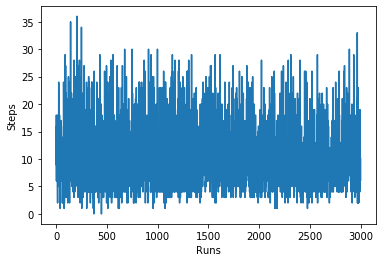

In [23]:
# plot result
plt.plot(reward_list)
plt.ylabel('Steps')
plt.xlabel('Runs')

Text(0.5, 0, 'Runs')

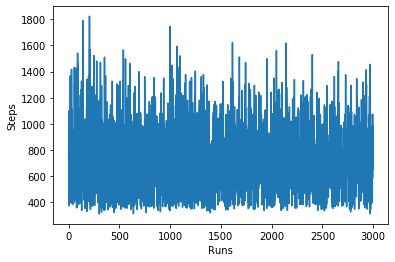

In [24]:
plt.plot(step_list)
plt.ylabel('Steps')
plt.xlabel('Runs')

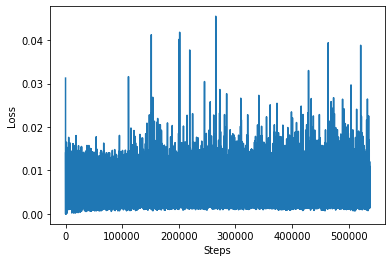

In [25]:
# plot loss
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.show()

In [ ]:
# For saving and loading files
saver = tf.train.Saver()

In [25]:
# Test the model and get average rewards
with tf.Session() as sess:
    
    # Load the model
    saver.restore(sess, "./D3QN_PER_TF_model/model.ckpt")
    
    # Run Tests
    N_tests = 20
    steps, total_reward = test(N_tests, model = DQNetwork, memory = None)
    
print("Average rewards over {} episodes is {}".format(N_tests, total_reward))

INFO:tensorflow:Restoring parameters from ./D3QN_PER_models/model.ckpt
Average rewards over 20 episodes is 175.49999999999997


In [22]:
with tf.Session() as sess:

    # Load the model
    saver.restore(sess, "./D3QN_PER_TF_model/model.ckpt")

    # Initialise environment 
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)

    done = False 
    total_reward = 0
    steps = 0

    # Until done 
    while not done:

        # render the current environment 
        env.render()

        # take an action using model
        Q_values= sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state[tf.newaxis,...]})
        action = np.argmax(Q_values[0])
        next_state, reward, done, info = env.step(action)
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
        state = next_state

        total_reward += reward
        steps += 1

        # pause for visualisation
        time.sleep(0.01)

    env.close()
    print ("Score: {}, Steps: {}".format(total_reward, steps))

INFO:tensorflow:Restoring parameters from ./D3QN_PER_TF_model/model.ckpt
Score: 120.0, Steps: 653
